In [1]:
import pandas as pd
import os 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.pipeline import Pipeline
from sklearn import preprocessing, model_selection
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression


import datetime as dt

np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline 


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def fix_num_cols(dframe, skiplist, dropcol=1):
    n = 0
    m = 0
    for col in dframe.columns.values:
        if col not in skiplist:
            if isinstance(dframe[col].dtype,((object))):
                try:
                    #dframe[col].fillna(dframe[col].mean(), inplace=True)
                    dframe[col].fillna(dframe[col].median(), inplace=True)
                    m+=1
                except:
                    print('error: ' + col)
                    if dropcol:
                        dframe.drop(col, inplace=True, axis=1)
                    else:
                        n+=1
                        #print(col)
                        #dframe[col] = dframe[col].astype('category').cat.codes
                        dframe[col].fillna('NUL', inplace=True)
    print(n)
    print(m)
    return dframe

In [3]:
if __name__ == "__main__":
    print (dt.datetime.now())
    dir_path = os.getcwd() + '/../../../data/all/'
    print (dir_path)
    df = pd.read_csv(dir_path + 'train.csv')
    df_macro = pd.read_csv(dir_path + 'macro.csv')

    df['price_length'] = [7.5 if cat > 6e6 and cat < 1e7 else len(str(cat)) for cat in df['price_doc'] ]
    
    df['price_length'] = [l if l < 8 else 8 for l in df['price_length']]
    
    df['price_cat'] = df['price_length'].astype('category').cat.codes
    
    df['quarter'] = df['timestamp'].apply(lambda x: pd.Timestamp(x).quarter)
    
    df.loc[df.price_cat == 4, 'price_cat'] = 3
    df_eda = pd.merge(df, df_macro, how='inner', on='timestamp', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)
    
    null_yr = 9999.0
    yr = dt.datetime.now().year
    # take care of bad dates, dates too old, too far out into the future, or NaN. Set them all to 9999.0
    for i in df_eda['build_year'].index:
        if df_eda.loc[i, 'build_year'] < 1700 \
                or np.isnan(df_eda.loc[i, 'build_year']) \
                or df_eda.loc[i, 'build_year'] > yr:
            df_eda.loc[i, 'build_year'] = null_yr

    df_eda.drop(['price_length','id', 'timestamp'], inplace=True, axis=1)
    
    print (dt.datetime.now())

2018-11-15 10:18:23.329166
/Users/chadleonard/Springboard/work/springboard/capstone/projects/capstone1_Sberbank/../../../data/all/
2018-11-15 10:18:34.559679


Possible values for **palette** are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, 
    CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, 
    Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG,
    PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, 
    RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, 
    Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, 
    YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, 
    bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, 
    copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, 
    gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, 
    gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, 
    hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, 
    nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, 
    rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, 
    tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, 
    viridis_r, vlag, vlag_r, winter, winter_r

[Text(0.5,1,'Distribution of build year with Bad Dates')]

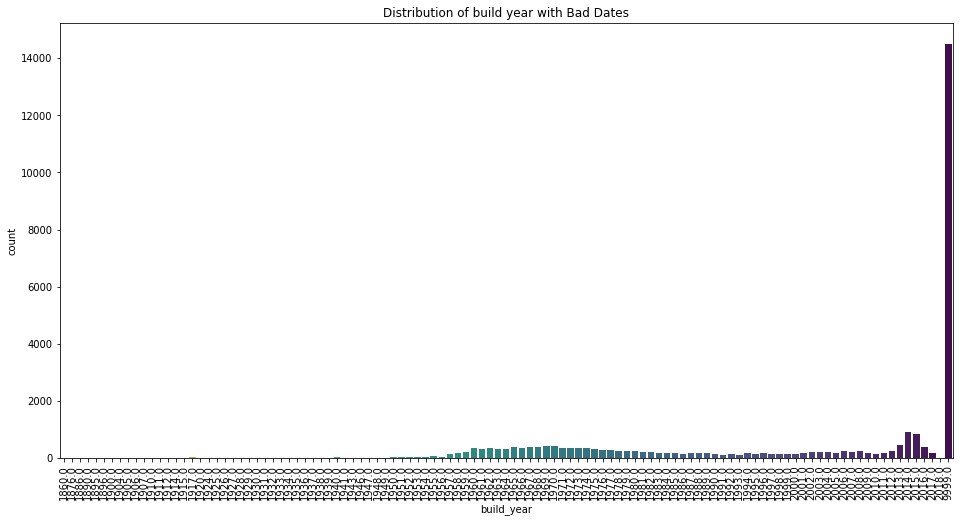

In [12]:
f, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation='90')
by_df = df_eda.sort_values(by=['build_year'])
sns.countplot(x=by_df['build_year'],palette="viridis_r")
ax.set(title='Distribution of build year with Bad Dates')

15960
14158    1860.0
27751    1860.0
17212    1876.0
29517    1886.0
23174    1890.0
Name: build_year, dtype: float64


[Text(0.5,1,'Distribution of build year without Bad Dates')]

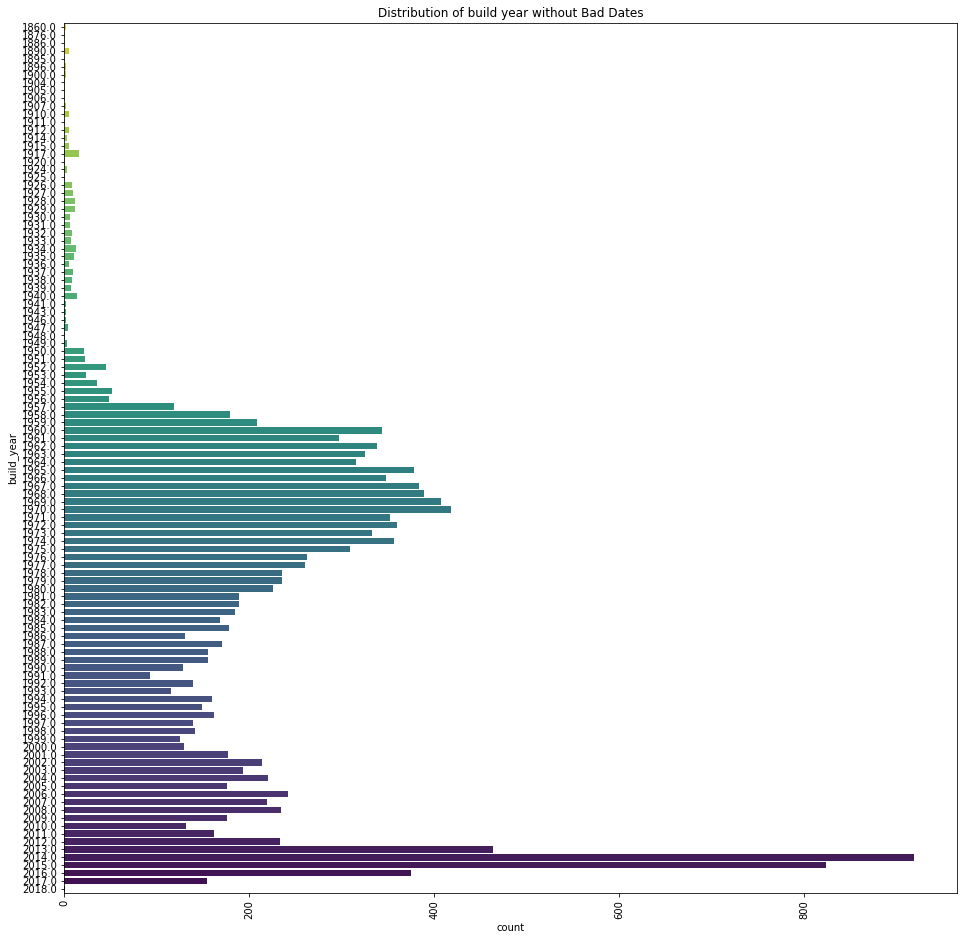

In [13]:
f, ax = plt.subplots(figsize=(16, 16))
plt.xticks(rotation='90')
not_ind = df_eda[(df_eda['build_year'] != null_yr)].index
print(len(not_ind))
by_df = df_eda.loc[not_ind].sort_values(by=['build_year'])
print(by_df['build_year'].head())
sns.countplot(y=by_df['build_year'],palette="viridis_r")
ax.set(title='Distribution of build year without Bad Dates')

15960


[Text(0.5,1,'Distribution of build years without Bad Dates')]

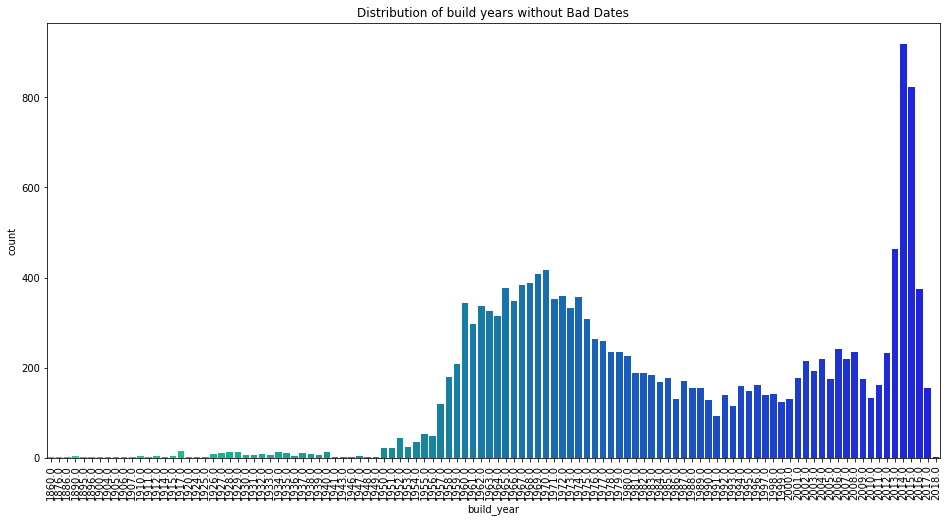

In [14]:
f, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation='90')
not_ind = df_eda[(df_eda['build_year'] != null_yr)].index
print(len(not_ind))
by_df = df_eda.loc[not_ind].sort_values(by=['build_year'])
sns.countplot(x=by_df['build_year'],palette="winter_r")
ax.set(title='Distribution of build years without Bad Dates')

15777


[Text(0.5,1,'Distribution of build years 1940 to Present')]

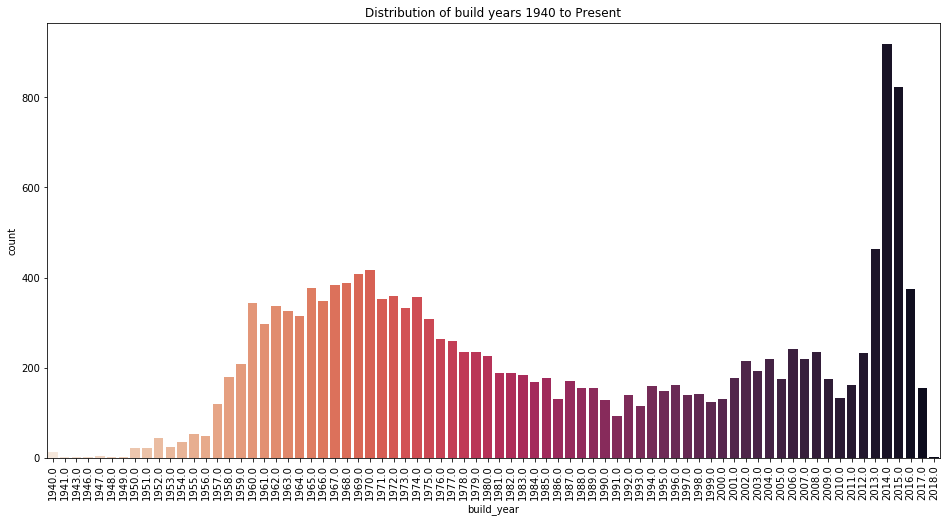

In [19]:
f, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation='90')
not_ind = df_eda[((df_eda['build_year'] != null_yr)) & (df_eda['build_year'] >= 1940.0)].index
print(len(not_ind))
by_df = df_eda.loc[not_ind].sort_values(by=['build_year'])
sns.countplot(x=by_df['build_year'],palette="rocket_r")
ax.set(title='Distribution of build years 1940 to Present')

183


[Text(0.5,1,'Distribution of build years before 1940')]

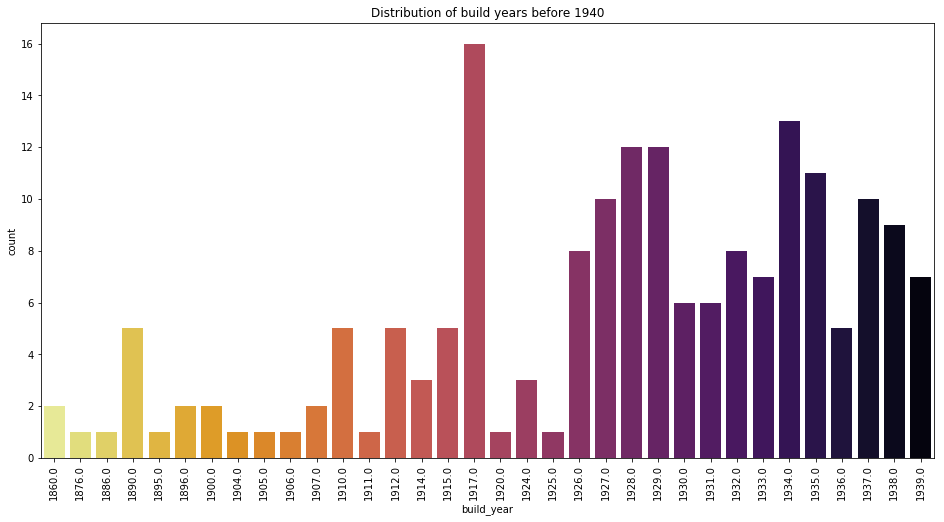

In [17]:
f, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation='90')
not_ind = df_eda[(df_eda['build_year'] < 1940.0)].index
print(len(not_ind))
by_df = df_eda.loc[not_ind].sort_values(by=['build_year'])
sns.countplot(x=by_df['build_year'],palette="inferno_r")
ax.set(title='Distribution of build years before 1940')

In [128]:
df_eda['build_year'].value_counts()
pass

In [51]:
dt.datetime.now().year
for k in bad_yr.keys():
    df_eda[df_eda['build_year'] == k] = null_yr

In [43]:
print(df_eda['build_year'].max())
print(df_eda['build_year'].min())
df_eda['build_year'].value_counts()

20052009.0
0.0


9999.9        13605
2014.0          919
2015.0          824
0.0             530
2013.0          464
1970.0          418
1969.0          407
1968.0          389
1967.0          384
1965.0          378
2016.0          375
1.0             368
1972.0          360
1974.0          357
1971.0          352
1966.0          348
1960.0          344
1962.0          338
1973.0          333
1963.0          325
1964.0          315
1975.0          309
1961.0          297
1976.0          263
1977.0          260
2006.0          242
1979.0          236
1978.0          235
2008.0          234
2012.0          233
              ...  
1912.0            5
1947.0            4
1949.0            3
1914.0            3
1924.0            3
1941.0            2
3.0               2
1943.0            2
1860.0            2
1896.0            2
1946.0            2
1907.0            2
1900.0            2
1895.0            1
1691.0            1
20052009.0        1
1911.0            1
2018.0            1
215.0             1


**IMPORTANT NOTES ABOUT FEATURES**

THESE ARE SOME OF THE SUMMARY NOTES GAINED FROM KAGGLE DISCUSSIONS, QUESTIONS AND ANSWERS FROM SBERBANK

- CHECK LIFE SQ, FULL SQ, KITCH SQ FOR CONSISTENCY (DONE)

- BUILD YEAR CAN BE IN FUTURE - PRE INVESTMENT TYPE (DONE)

- BUILD YEAR 0 AND 1 ARE MISTAKES (DONE)

- CHECK TRAIN AND TEST PRODUCT TYPES (DONE)

- CHECK NUM OF ROOMS FOR CONSISTENCY (DONE)

- MATERIAL EXPLAINED: 1 - panel, 2 - brick, 3 - wood, 4 - mass concrete, 5 - breezeblock, 6 - mass concrete plus brick

- STATE EXPLAINED: 4 BEST 1 WORST

- KITCHEN INCLUDED IN LIFE SQ CHECK INCONSISTENCY (DONE)

- FULL SQ > LIFE SQ (MOST PROBABLY) (DONE)

- KM DISTANCES ARE AIRLINE DISTANCES

- RAION POPUL AND FULL ALL ARE SAME CALC FROM DIFF SOURCES

**website:**    https://www.kaggle.com/c/sberbank-russian-housing-market/discussion/35755

https://www.kaggle.com/captcalculator/a-very-extensive-sberbank-exploratory-analysis

https://www.kaggle.com/agzamovr/a-very-extensive-exploratory-analysis-in-python

https://www.kaggle.com/keremt/very-extensive-cleaning-by-sberbank-discussions


**Feature Engineering**

Yes, just one feature and you might get 0.03-0.045 jump in your score.

**areadiff = fullsq - kitch_sq, this feature.**



I don't know how many of you found out about this feature, because all the public kernels didn't mention this feature and even still the top participants haven't talked about this. 

In all the public kernels, i saw that:
1.  fullsq was divided either by lifesq or by kitchsq, but no one seemed to be interested in 
2. taking the difference between fullsq and lifesq, which would not only tell us the true lifesq but also it greatly characterises the missing or false fullsq values by giving it negative sign, if fullsq is less than kitchsq. 
3. This feature brought me from 32.00 to 31.603 on Pub.LB and gave me 31.710 on Pvt.LB. This feature had the second highest correlation(even greater than fullsq) after num_room(i think!) with the target variable. You can make this feature in your kernel and verify everything what i said.

In [20]:
df_eda['target'] = pd.Series([0 if t != 0 else 1 for t in df_eda['price_cat'] ])
df_eda['target'].value_counts()

0    30238
1      233
Name: target, dtype: int64

In [6]:
df_eda['target_1'] = pd.Series([0 if t != 1 else 1 for t in df_eda['price_cat'] ])
df_eda['target_1'].value_counts()

0    16721
1    13750
Name: target_1, dtype: int64

In [8]:
df_eda['target_2'] = pd.Series([0 if t != 2 else 1 for t in df_eda['price_cat'] ])
df_eda['target_2'].value_counts()

0    18793
1    11678
Name: target_2, dtype: int64

In [4]:
df_eda['target_3'] = pd.Series([0 if t != 3 else 1 for t in df_eda['price_cat'] ])
df_eda['target_3'].value_counts()

0    25661
1     4810
Name: target_3, dtype: int64

In [9]:
av = df_eda['target_2'].value_counts()
weights = dict()
print(av)
for a in av.index:
    print(a)
    weights.update({a: av.loc[a]/sum(av)})
weights

0    18793
1    11678
Name: target_2, dtype: int64
0
1


{0: 0.6167503527944603, 1: 0.38324964720553967}

In [4]:
df_eda['areadiff'] = df_eda['full_sq'] - df_eda['kitch_sq']
df_eda['areadiff'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: areadiff, dtype: float64

In [6]:
skip = ['timestamp', 'price_doc', 'price_cat','target','target_1','target_2','target_3']
df_train = fix_num_cols(df_eda, skip, 0)
#print(len(df_train.columns.values))
#df_train = fix_num_cols(df_train, skip, 0)
df_train = pd.get_dummies(df_train)

print(len(df_train.columns.values))
df_train.head()

error: product_type
error: sub_area
error: culture_objects_top_25
error: thermal_power_plant_raion
error: incineration_raion
error: oil_chemistry_raion
error: radiation_raion
error: railroad_terminal_raion
error: big_market_raion
error: nuclear_reactor_raion
error: detention_facility_raion
error: water_1line
error: big_road1_1line
error: railroad_1line
error: ecology
error: child_on_acc_pre_school
error: modern_education_share
error: old_education_build_share
18
372
564


,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,"child_on_acc_pre_school_7,311",child_on_acc_pre_school_NUL,"modern_education_share_90,92","modern_education_share_93,08","modern_education_share_95,4918",modern_education_share_NUL,"old_education_build_share_23,14","old_education_build_share_25,47","old_education_build_share_8,2517",old_education_build_share_NUL
0,43,27.0,4.0,12.0,1.0,1979.0,2.0,6.0,2.0,6.407578e+06,...,0,0,0,0,0,1,0,0,0,1
1,34,19.0,3.0,12.0,1.0,1979.0,2.0,6.0,2.0,9.589337e+06,...,0,0,0,0,0,1,0,0,0,1
2,43,29.0,2.0,12.0,1.0,1979.0,2.0,6.0,2.0,4.808270e+06,...,0,0,0,0,0,1,0,0,0,1
3,89,50.0,9.0,12.0,1.0,1979.0,2.0,6.0,2.0,1.258354e+07,...,0,0,0,0,0,1,0,0,0,1
4,77,77.0,4.0,12.0,1.0,1979.0,2.0,6.0,2.0,8.398461e+06,...,0,0,0,0,0,1,0,0,0,1


In [7]:
#skip = ['timestamp', 'price_doc', 'price_cat','target', 'target_1']
tgt = 'price_cat'
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_train.loc[:,~df_train.columns.isin(skip)], \
                                                                df_train[tgt], test_size=0.3)
X_train.shape

(21329, 562)

In [14]:
print (dt.datetime.now())
clf = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression(multi_class='ovr', n_jobs=2))),
  ('classification', RandomForestClassifier())
])
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print (dt.datetime.now())

2018-11-08 10:43:50.972763


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


0.7638372347407569
2018-11-08 10:44:38.484273


In [18]:
clf = LogisticRegression(multi_class='ovr', n_jobs=2).fit(X_train, y_train)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X_train)
X_new.shape

/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


(21329, 85)

In [23]:
model.fit(X_new, y_test)

NotFittedError: Since 'prefit=True', call transform directly

In [21]:
X_train = df_train.loc[:,~df_train.columns.isin(skip)]
y_train = df_train['target_2']
X_train.shape

(30471, 562)

In [26]:
y_tn = df_eda['price_doc']

In [28]:
corlist_cont = []
corlist_discrete = []

for col in X_train.columns.values:
    if col not in skip:
        X_corr = np.corrcoef(X_train[col],y_train)
        X_disc = np.corrcoef(X_train[col],y_tn)
        corlist_cont.append((np.abs(X_corr[1][0]), col))
        corlist_discrete.append((np.abs(X_disc[1][0]), col))
corlist_discrete = sorted(corlist_discrete, reverse=True)
corlist_cont = sorted(corlist_cont, reverse=True)

for a in corlist_discrete:
    if 'areadiff' in a:
        print(a)
        
for a in corlist_cont:
    if 'areadiff' in a:
        print(a)

(0.27909329382102877, 'areadiff')
(0.011558935835008348, 'areadiff')


In [221]:
# Logistic Regression Multi-class Classifier ==> class 3
from sklearn.linear_model import LogisticRegression

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       #('pca', PCA(whiten=True)),
       ('clf', LogisticRegression(multi_class='ovr', n_jobs=2)) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__fit_intercept": [False]  , "clf__solver": ['liblinear', 'sag'] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())

2018-11-02 19:34:01.323956
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__fit_intercept=False, clf__solver=liblinear .................
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9052977027660571, total=  47.4s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9085794655414908, total=  53.1s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9104547585560244, total=  32.9s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9106891701828411, total=  52.3s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8595874355368026, total=  10.4s
[CV] clf__fit_intercept=False, clf__solver=sag .......................
[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9144397562119081, total=  45.4s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8534927332395686, total=  10.1s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8448195030473511, total=   9.7s


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] clf__fit_intercept=False, clf__solver=sag .......................
[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8384903891233005, total=   9.6s


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.843413033286451, total=   9.5s


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  2.5min finished
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


{'clf__fit_intercept': False, 'clf__solver': 'liblinear'}
0.9098921706516643
[0.91575925 0.85757487]
[0.90989217 0.84796062]
2018-11-02 19:37:14.090918


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [212]:
# Logistic Regression Multi-class Classifier ==> class 2
from sklearn.linear_model import LogisticRegression

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       #('pca', PCA(whiten=True)),
       ('clf', LogisticRegression(multi_class='ovr', n_jobs=2)) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__fit_intercept": [False]  , "clf__solver": ['liblinear', 'sag'] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())

2018-11-02 19:13:28.620684
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__fit_intercept=False, clf__solver=liblinear .................
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.6289263947491796, total=  18.9s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.6108766994842945, total=  19.7s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.6082981715893109, total=  19.7s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.6169714017815283, total=  20.8s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.6247069854664792, total=  10.3s
[CV] clf__fit_intercept=False, clf__solver=sag .......................
[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.6148616971401781, total=  18.6s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.6022034692920769, total=  10.7s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.6118143459915611, total=  10.1s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.616502578527895, total=   9.9s


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.6108766994842945, total=   9.7s


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.3min finished
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


{'clf__fit_intercept': False, 'clf__solver': 'liblinear'}
0.6159868729488983
[0.64286468 0.63907871]
[0.61598687 0.61322082]
2018-11-02 19:15:19.046551


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [214]:
# Logistic Regression Multi-class Classifier ==> class 1
from sklearn.linear_model import LogisticRegression

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       #('pca', PCA(whiten=True)),
       ('clf', LogisticRegression(multi_class='ovr', n_jobs=2, class_weight=weights)) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__fit_intercept": [False]  , "clf__solver": ['liblinear', 'sag'] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())

2018-11-02 19:16:42.760329
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__fit_intercept=False, clf__solver=liblinear .................
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.829817158931083, total=  30.6s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.8195030473511487, total=  32.8s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.8248945147679325, total=  19.6s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.8347398030942335, total=  27.5s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8185654008438819, total=  10.2s
[CV] clf__fit_intercept=False, clf__solver=sag .......................
[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.8288795124238162, total=  21.2s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.813173933427098, total=  10.2s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8134083450539147, total=  10.2s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8227848101265823, total=  10.1s


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8263009845288326, total=   9.9s


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.6min finished
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


{'clf__fit_intercept': False, 'clf__solver': 'liblinear'}
0.8275668073136427
[0.8395124  0.82659556]
[0.82756681 0.81884669]
2018-11-02 19:18:49.943877


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [219]:
# Logistic Regression Multi-class Classifier ==> class 0
from sklearn.linear_model import LogisticRegression

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       #('pca', PCA(whiten=True)),
       ('clf', LogisticRegression(multi_class='ovr', n_jobs=2, class_weight=weights)) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__fit_intercept": [False]  , "clf__solver": ['liblinear', 'sag'] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())

2018-11-02 19:24:02.339697
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__fit_intercept=False, clf__solver=liblinear .................
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.8940459446788561, total=  29.5s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9102203469292077, total=  48.7s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9104547585560244, total=  32.2s
[CV] clf__fit_intercept=False, clf__solver=liblinear .................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9027191748710736, total=  42.0s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8105954055321144, total=  10.0s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8255977496483825, total=  10.0s
[CV] clf__fit_intercept=False, clf__solver=sag .......................
[CV]  clf__fit_intercept=False, clf__solver=liblinear, score=0.9123300515705579, total=  50.7s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8075480543834974, total=   9.9s
[CV] clf__fit_intercept=False, clf__solver=sag .......................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8021565869667135, total=   9.9s


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  clf__fit_intercept=False, clf__solver=sag, score=0.8204406938584153, total=   9.5s


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  2.2min finished
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


{'clf__fit_intercept': False, 'clf__solver': 'liblinear'}
0.9059540553211439
[0.91747055 0.82248139]
[0.90595406 0.8132677 ]
2018-11-02 19:26:57.816390


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [187]:
print (dt.datetime.now())
pipe = Pipeline([
       #('scaling', preprocessing.StandardScaler()),
       #('pca', PCA(whiten=True)),
       ('clf', RandomForestClassifier(random_state=0, n_jobs=2,class_weight=weights )) 
    ])


print(len(X_train.columns.values))

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__n_estimators": [500] , "clf__max_depth": [10]} #, "pca__n_components": [5, 10]}
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, \
                                           scoring='accuracy', verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())

2018-11-02 16:11:25.852977
561
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.7121425222691046, total=  21.3s
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.7149554617909049, total=  21.3s
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.710267229254571, total=  19.5s
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.710267229254571, total=  19.5s
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.7069854664791374, total=  19.9s


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.1min finished


{'clf__max_depth': 10, 'clf__n_estimators': 500}
0.7109235818096578
[0.79915607]
[0.71092358]
2018-11-02 16:12:56.086487


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [188]:
len(X_train.columns.values)

561